# HA's Fruit Supply Business Report

##### Conducted by: Khang Le Nhu Gia

### Business context

"HA" is a newly established firm operated in Viet Nam specializing in supplying various type of fruits for one of Vietnam largest distributor (will not be disclosed in this report due to privacy).

For the scope of this project, timeline is between 01/10/2022 (the day the shop established) and 15/11/2022. Since this is a newly established shop, this project will only address two main question as following:
- Which are the top performing provinces, shops and products regarding revenue?
- How are drop-rates distributed across provinces, shops and products?

Answering these two question will help the firm have a accurate perspective about their main revenue generators as well as determine whether there is inefficiency in their operations (high drop-rate indicates insufficient stocks or unqualified products).

### Data extraction using web scrapping

In [11]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sns

In [12]:
directory = 'C://Users//admin//Desktop//2022//'
credential = open(directory + 'password.txt')
line = credential.readlines()
email = str(line[0].split()[0])
password = str(line[1].split()[0])
landing_page = str(line[2].split()[0])
login_url = str(line[3].split()[0])
po_page_url = str(line[4].split()[0])
import_page_url = str(line[5].split()[0])
export_detail_url = str(line[6].split()[0])
from_date = input('Input start date (format: yyyy-mm-dd) ')
to_date = input('Input end date (format: yyyy-mm-dd) ')
list_PO = []
chained_PO_code = ''
excel_url = []

Input start date (format: yyyy-mm-dd) 2022-10-01
Input end date (format: yyyy-mm-dd) 2022-11-15


In [13]:
def login(email, password):
    payload_login = {
    'Email': email, 
    'Password': password
    }
    s = requests.Session()
    r = s.get(landing_page)
    soup = BeautifulSoup(r.content, 'html.parser')
    payload_login['__RequestVerificationToken'] = soup.find('input', attrs={"name" : "__RequestVerificationToken"})['value']
    login = s.post(login_url, data = payload_login)
    return s

In [14]:
def import_page_1():
    session = login(email, password)
    payload = {'p': '1',
               'fromDate': from_date,
               'toDate': to_date,
               'st': '1',
               'doccodes': ''
              }
    import_page_no_1 = session.post(import_page_url, data = payload).text
    import_page_no_1 = BeautifulSoup(import_page_no_1, 'html.parser')
    import_table = import_page_no_1.find_all('tr')
    total_row = len(import_table)
    global chained_PO_code
    for n in range(1, total_row):
        PO = (import_table[n].find_all('td', attrs = {'class': 'sub_col'})[2]
                             .getText()
                             .split()[0])
        chained_PO_code = chained_PO_code + "," + PO
    chained_PO_code = chained_PO_code[1:]
    return import_page_no_1

In [15]:
def import_page_until_end():
    next_page_button = import_page_1().find('li', attrs = {'class':"paginate_button next"})
    while next_page_button is not None:
        next_page_butt_url = next_page_button.find('a')['href']
        next_page_number = next_page_butt_url.split("&")[-1].split("=")[-1]
        session = login(email, password)
        payload = {'p': next_page_number,
                   'fromDate': from_date,
                   'toDate': to_date,
                   'st': '1',
                   'doccodes': ''
                  }
        next_import_page = session.post(import_page_url, data = payload).text
        next_import_page = BeautifulSoup(next_import_page, 'html.parser')
        next_page_button = next_import_page.find('li', attrs = {'class':"paginate_button next"})
        import_table = next_import_page.find_all('tr')
        total_row = len(import_table)
        global chained_PO_code
        for n in range(1, total_row):
            PO = (import_table[n].find_all('td', attrs = {'class': 'sub_col'})[2]
                                 .getText()
                                 .split()[0])
            chained_PO_code = chained_PO_code + "," + PO
    print(chained_PO_code)

In [16]:
def PO_page():
    session = login(email, password)
    payload = {'p': '1',
               'ps': '100',
               'status': '130',
               'fdt': '1',
               'fromDate': '',
               'toDate': '',
               'vs': '',
               'city': '0',
               'ndest': '0',
               'code': chained_PO_code,
               'tsi': ''
                }
    page = session.post(po_page_url, data = payload).text
    page = BeautifulSoup(page, 'html.parser')
    all_PO = page.find_all("a", attrs = {'class': 'Tip_mouse_on lnkURL'})
    for link in all_PO:
        text = link['href']
        text = text.split("-")[-1]
        start = 0
        end = text.index('?')
        code = text[start:end]
        url = export_detail_url + code
        list_PO.append(directory + code + '.xlsx')
        excel_url.append(url)
    return page

In [17]:
def PO_page_until_end():
    next_page_button = PO_page().find('li', attrs = {'class':"paginate_button next"})
    while next_page_button is not None:
        next_page_butt_url = next_page_button.find('a')['href']
        next_page_number = next_page_butt_url.split("&")[-1].split("=")[-1]
        print(next_page_number)
        session = login(email, password)
        payload = {'p': next_page_number,
                   'ps': '100',
                   'status': '130',
                   'fdt': '1',
                   'fromDate': '',
                   'toDate': '',
                   'vs': '',
                   'city': '0',
                   'ndest': '0',
                   'code': chained_PO_code,
                   'tsi': ''
                   }
        page = session.post(po_page_url, data = payload).text
        page = BeautifulSoup(page, 'html.parser')
        all_PO = page.find_all("a", attrs = {'class': 'Tip_mouse_on lnkURL'})
        for link in all_PO:
            text = link['href']
            text = text.split("-")[-1]
            start = 0
            end = text.index('?')
            code = text[start:end]
            url = export_detail_url + code
            list_PO.append(directory + code + '.xlsx')
            excel_url.append(url)
        print(len(excel_url))

In [18]:
def download(name, link):
    session = login(email, password)
    with open(name, 'wb') as f:
        for chunk in session.get(link).iter_content(chunk_size = 8192):
            if chunk:
                f.write(chunk)
            print(name +': successful')

In [19]:
def change_shop_name(shop):
    return shop[2:]

In [20]:
import_page_until_end()

4144196709,4144203714,4144196766,4144196761,4144203718,4144203586,4144196708,4144028921,4144157556,4144196705,4144201891,4144157472,4144028753,4144146807,4144028749,4144086579,4144028774,4144086575,4144028722,4144028639,4144028604,4144086211,4144082943,4144028641,4144027340,4144027336,4144028586,4144058712,4144028542,4144027464,4144028498,4144026468,4144028531,4144026472,4144044818,4143856874,4144028498,4144026468,4144020156,4143856879,4143954692,4143856841,4143954781,4143856919,4143915074,4143856918,4143914390,4143914393,4143914392,4143856863,4143856921,4143856255,4143856116,4143856120,4143900975,4143856792,4143855977,4143682256,4143855980,4143854695,4143682248,4143789171,4143789167,4143734701,4143819076,4143682245,4143734697,4143685216,4143682228,4143685220,4143685287,4143685287,4143685284,4143682224,4143685286,4143686475,4143686800,4143697993,4143447788,4143683460,4143670585,4143447785,4143585914,4143653671,4143629448,4143650416,4143637184,4143447533,4143507148,4143583296,4143603677

In [21]:
PO_page_until_end()

In [22]:
for num in range(len(excel_url)):
    download(list_PO[num], excel_url[num])

C://Users//admin//Desktop//2022//102105974.xlsx: successful
C://Users//admin//Desktop//2022//102124124.xlsx: successful
C://Users//admin//Desktop//2022//102105455.xlsx: successful
C://Users//admin//Desktop//2022//102124371.xlsx: successful
C://Users//admin//Desktop//2022//102105983.xlsx: successful
C://Users//admin//Desktop//2022//102105981.xlsx: successful
C://Users//admin//Desktop//2022//102124440.xlsx: successful
C://Users//admin//Desktop//2022//102105937.xlsx: successful
C://Users//admin//Desktop//2022//102123975.xlsx: successful
C://Users//admin//Desktop//2022//101696188.xlsx: successful
C://Users//admin//Desktop//2022//102010152.xlsx: successful
C://Users//admin//Desktop//2022//101695988.xlsx: successful
C://Users//admin//Desktop//2022//102010035.xlsx: successful
C://Users//admin//Desktop//2022//101696008.xlsx: successful
C://Users//admin//Desktop//2022//101993153.xlsx: successful
C://Users//admin//Desktop//2022//101849340.xlsx: successful
C://Users//admin//Desktop//2022//1016959

### Data transformation

In [23]:
df1 = pd.read_excel(list_PO[0])
df2 = list_PO[1:]
for file in df2:
    df2 = pd.read_excel(file)
    df1 = pd.concat([df1, df2])

In [24]:
df1.head()

,STT,Mã đơn hàng,Miền,Tỉnh,Mã NCC (Site nguồn),Tên NCC,Địa chỉ NCC,Mã Sub Range,Tên Sub Range,Mã điểm giao,...,Ngày NCC hẹn giao hàng,Khung giờ hẹn giao hàng,Ngày xác nhận giao hàng,Khung giờ xác nhận giao hàng,Ngày giao hàng,Ngày gia hạn,Trạng thái,Ngày cập nhật,Chú thích 1,Chú thích 2
0,1,4144196709,Miền Nam,TP. Hồ Chí Minh,2008400,CTY TNHH TM XNK THỰC PHẨM HÒA AN,"351/5C Lê Đại Hành, Phường 11, Quận 11,",NaN,NaN,1218,...,NaN,NaN,NaN,NaN,2022-11-15 21:01:36,NaN,Đã giao hàng,2022-11-16 21:05:01.877,NaN,NaN
0,1,4144203586,Miền Nam,TP. Hồ Chí Minh,2008400,CTY TNHH TM XNK THỰC PHẨM HÒA AN,"351/5C Lê Đại Hành, Phường 11, Quận 11,",NaN,NaN,1113,...,NaN,NaN,NaN,NaN,2022-11-14 01:41:12,NaN,Đã giao hàng,2022-11-16 01:45:00.783,NaN,NaN
1,2,4144203586,Miền Nam,TP. Hồ Chí Minh,2008400,CTY TNHH TM XNK THỰC PHẨM HÒA AN,"351/5C Lê Đại Hành, Phường 11, Quận 11,",NaN,NaN,1113,...,NaN,NaN,NaN,NaN,2022-11-14 01:41:12,NaN,Đã giao hàng,2022-11-16 01:45:00.783,NaN,NaN
0,1,4144196708,Miền Nam,TP. Hồ Chí Minh,2008400,CTY TNHH TM XNK THỰC PHẨM HÒA AN,"351/5C Lê Đại Hành, Phường 11, Quận 11,",NaN,NaN,1218,...,NaN,NaN,NaN,NaN,2022-11-14 01:39:47,NaN,Đã giao hàng,2022-11-16 01:40:00.530,NaN,NaN
0,1,4144203714,Miền Trung,TP. Đà Nẵng,2008400,CTY TNHH TM XNK THỰC PHẨM HÒA AN,"351/5C Lê Đại Hành, Phường 11, Quận 11,",NaN,NaN,1237,...,NaN,NaN,NaN,NaN,2022-11-15 01:23:24,NaN,Đã giao hàng,2022-11-16 01:25:00.693,NaN,NaN


In [25]:
df1 = (df1.filter(['Mã đơn hàng',
                  'Tỉnh',
                  'Tên điểm giao',
                  'Tên hàng',
                  'ĐVT',
                  'Đơn giá',
                  'Số lượng đặt hàng',
                  'Số lượng thực tế giao hàng',
                  'Ngày đặt hàng',
                  'Ngày giao hàng'])
          .reset_index(drop = True))

In [26]:
df1 = df1.rename(columns = {'Mã đơn hàng': 'po',
                            'Tỉnh': 'province',
                            'Tên điểm giao': 'shop',
                            'Tên hàng': 'product',
                            'ĐVT': 'measurement',
                            'Đơn giá': 'price',
                            'Số lượng đặt hàng': 'amount_ordered',
                            'Số lượng thực tế giao hàng':'amount_delivered'
                            })

In [27]:
df1['revenue'] =  df1['price'] * df1['amount_delivered']
df1['drop_rate'] = 1 - (df1['amount_delivered'] / df1['amount_ordered'])

In [28]:
df1 = df1.replace({'province':{', TP. Hồ Chí Minh,' : 'TP. Hồ Chí Minh'}})

In [29]:
df1.province.unique()

array(['TP. Hồ Chí Minh', 'TP. Đà Nẵng', 'T. Bình Dương'], dtype=object)

In [30]:
df1['shop'] = df1['shop'].apply(change_shop_name)

In [31]:
df1.shop.unique()

array(['P_Fresh_Miền Nam_Trái Cây Nhập Kh',
       'T_Fresh_Miền Nam_Trái Cây Nhập Kh',
       'T_Fresh_Miền Trung_Trái Cây Nhập',
       'P_Fresh_Miền Trung_Trái cây Nhập', ' VCC HCM Landmark 81',
       ' VCC HCM Đồng Khởi', '+ HCM 26/4B Ấp Đông Lân',
       ' VCC HCM Thảo Điền', ' VC+ HCM Nguyễn Duy Trinh', ' HCM Hưng Gia',
       ' VCP HCM Ba Tháng Hai', ' VCP HCM Lê Văn Việt',
       ' VC+ HCM Phổ Quang', ' HCM Diamond', ' BDG Mỹ Phước 1',
       ' HCM Trung Sơn', ' HCM Bình Trưng'], dtype=object)

### Part 1: Revenue

Q1: How is revenue distributed across provinces?

<AxesSubplot:xlabel='province', ylabel='revenue'>

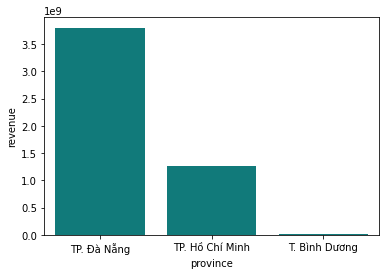

In [32]:
sns.barplot(data = (df1.groupby('province')
                        .agg('sum')
                        .filter(['province', 'revenue'])
                        .sort_values(by = 'revenue', ascending = False)
                        .reset_index()
                    ),
            x = 'province',
            y = 'revenue',
            color = 'darkcyan')

TP. Đà Nẵng and TP. Hồ Chí Minh generated the lion share of total revenue (with revenue from TP. Đà Nẵng almost tripled that from TP. Hồ Chí Minh). Later on, we will take a look at what are the main drivers (shops and products) of this trend.

Q2: Which are the top 5 stores generate the most revenue?

<AxesSubplot:xlabel='revenue', ylabel='shop'>

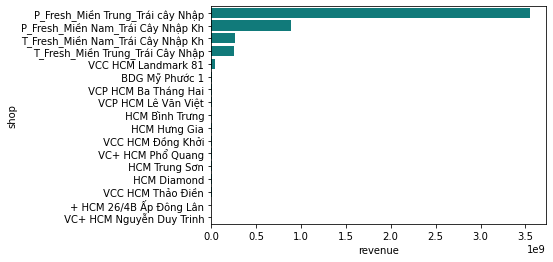

In [33]:
sns.barplot(data = (df1.groupby('shop')
                        .agg('sum')
                        .filter(['shop', 'revenue'])
                        .sort_values(by = 'revenue', ascending = False)
                        .reset_index()
                    ),
            y = 'shop',
            x = 'revenue',
            color = 'darkcyan')

The highest amount of revenue was generated by "P_Fresh_Miền Trung", a store from TP. Đà Nẵng; ranked in second is "P_Fresh Ho Chi Minh" from TP. Hồ Chí Minh. "T_Fresh_Miền Trung" which ranked at fourth is from TP. Đà Nẵng while the remaining stores are from either TP. Hồ Chí Minh or Bình Dương.

Q3: How is revenue distributed across products?

<AxesSubplot:xlabel='revenue', ylabel='product'>

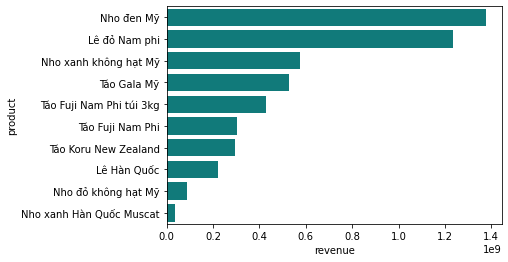

In [34]:
sns.barplot(data = (df1.groupby('product')
                       .agg('sum')
                       .sort_values(by = 'revenue', ascending = False)
                       .reset_index()),
            y = 'product',
            x = 'revenue',
            color = 'darkcyan')

There were two products that generated the most of total revenue: the first was "Nho đen Mỹ"; the second was "Lê Đỏ Nam Phi".

In [35]:
Q4: From the two stores that generated the highest revenue, which products are their main revenue drivers?

Object `drivers` not found.


In [ ]:
Q4: From the two stores that generated the highest revenue, which products are their main revenue drivers

<AxesSubplot:xlabel='revenue', ylabel='product'>

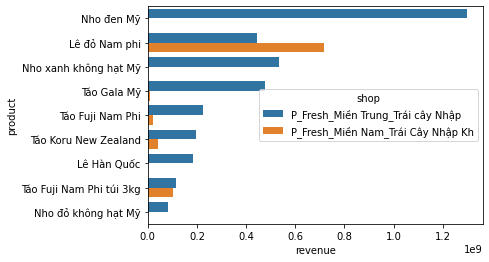

In [36]:
sns.barplot(data = (df1.query('shop == "P_Fresh_Miền Trung_Trái cây Nhập" or shop == "P_Fresh_Miền Nam_Trái Cây Nhập Kh"')
                       .groupby(['shop','product'])
                       .agg('sum')
                       .sort_values(by = 'revenue', ascending = False)
                       .reset_index()),
            y = 'product',
            x = 'revenue',
            hue = 'shop',)

Interestingly, "Nho đen Mỹ" was  supplied to only "P_Fresh_Miền Trung" from TP. Đà Nẵng not "P_Fresh_Miền Nam" from TP. Hồ Chí Minh. Despite this, "Nho đen Mỹ" contributed the most to total revenue.

### Part 2: Drop-rate

Q5: How is drop-rate distributed?

<AxesSubplot:xlabel='drop_rate', ylabel='Count'>

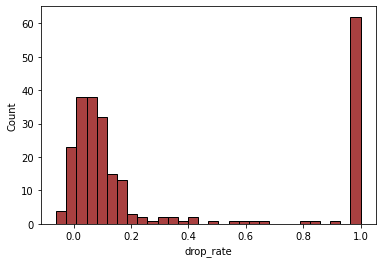

In [37]:
sns.histplot(data = df1, x = 'drop_rate', bins = 30, color = 'darkred')

Drop-rate distributed largely from 0%-20%, which was around the regular benchmark of the fruit industry. However, there was a spike in the number of orders that had 90%-100% drop-rate; which is quite unusual, we will discover why this happen later on.

Q6: How is drop-rate distributed across provinces?

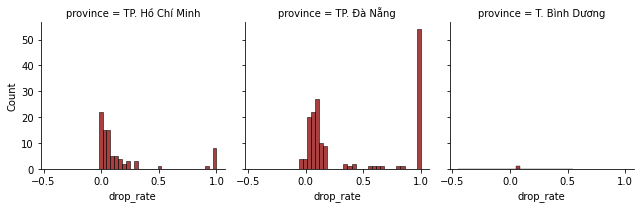

In [38]:
sns.FacetGrid(data = df1, col = 'province').map(sns.histplot, 'drop_rate', bins = 30, color = 'darkred')

Drilling the data to provinces we can see that the majority of orders that had drop-rates between 90%-100% came from TP. Đà Nẵng. We will continue drilling down to product-level in TP. Đà Nẵng to determine which products caused this.

Q7: How is drop-rate distributed across products sold in TP. Đà Nẵng?

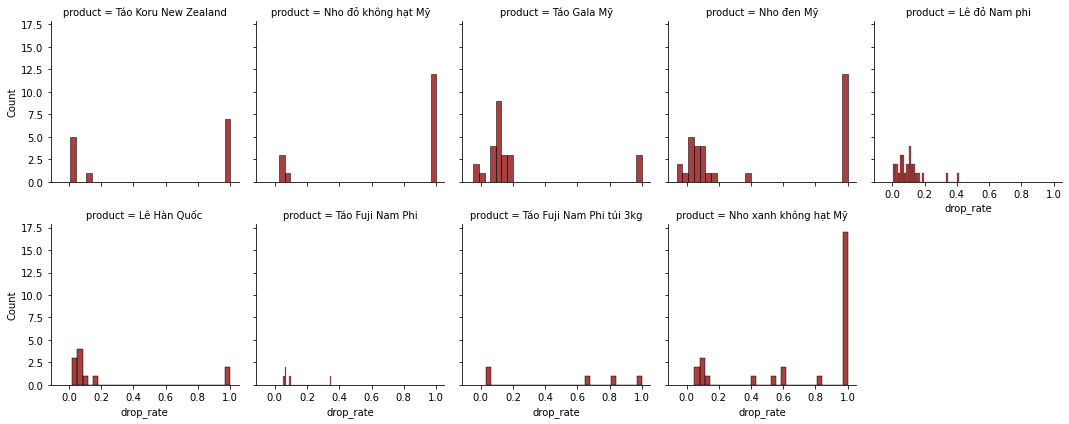

In [39]:
sns.FacetGrid(data = df1.query('province == "TP. Đà Nẵng"'), col = 'product', col_wrap = 5).map(sns.histplot, 'drop_rate', bins = 30, color = 'darkred')

It is now clear that "Nho đen Mỹ", "Nho đỏ không hạt Mỹ", "Nho xanh không hạt Mỹ" were the products that largely responsible for the 90-100% drop rate.

According to the operations team, for "Nho đen Mỹ", "Nho đỏ không hạt Mỹ", there was a problem with the freezer leading to a high number of products being rejected by the distributor; for "Nho đỏ không hạt Mỹ" despite high number of orders, this product was out-of-stock for the most part.

Despite high drop-rate, "Nho đen Mỹ" was ranked first and "Nho xanh không hạt Mỹ" was ranked third in terms of total revenue.

Q8: How is amount_ordered and amount_delivered correlate to one another?

<AxesSubplot:xlabel='amount_ordered', ylabel='amount_delivered'>

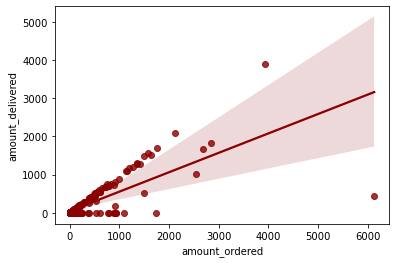

In [40]:
sns.regplot(data = df1,
                x = 'amount_ordered',
                y = 'amount_delivered',
                color = 'darkred')

In order to see if there was any more anomaly in drop-rate, we will look at the relationship between amount_ordered and amount_delivered. The upward sloping line indicates that most orders were; in fact, delivered; however there are two anomalies:
- Horizontal line of dots at amount_delivered = 0 indicates orders that have 90-100% drop-rate (which we have addressed earlier on)
- A dot at roughly (6000,450)

Q8: In TP. Hồ Chí Minh, how is amount_ordered and amount_delivered correlate to one another?

<AxesSubplot:xlabel='amount_ordered', ylabel='amount_delivered'>

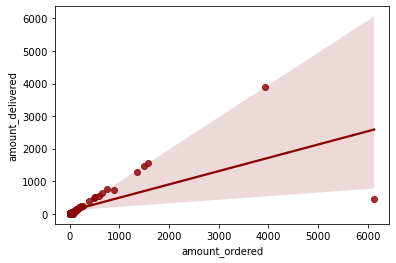

In [41]:
sns.regplot(data = df1.query('province == "TP. Hồ Chí Minh"'),
                x = 'amount_ordered',
                y = 'amount_delivered',
                color = 'darkred')

In TP. Hồ Chí Minh, most orders were delivered; there was no horizontal line of dots, and the dot at around (6000,450) we seen in the previous report also appears suggesting that this order was made in TP. Hồ Chí Minh.

Drill down to have a closer look at the peculiar order:

In [42]:
df1.query('province == "TP. Hồ Chí Minh" and amount_ordered > 6000')

,po,province,shop,product,measurement,price,amount_ordered,amount_delivered,Ngày đặt hàng,Ngày giao hàng,revenue,drop_rate
105,4143856841,TP. Hồ Chí Minh,P_Fresh_Miền Nam_Trái Cây Nhập Kh,Táo Fuji Nam Phi,KG,50000,6125.0,442.32,2022-11-04,2022-11-04 22:05:55,22116000.0,0.927784


This order, according to management, was not delivered as ordered because of insufficient stock.

Q9: Besides product's quality and availability, does price affect drop-rate?

<AxesSubplot:xlabel='price', ylabel='drop_rate'>

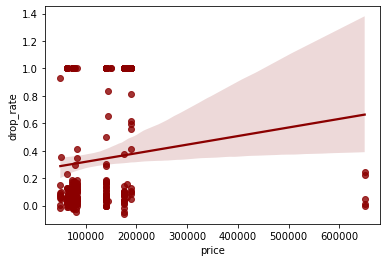

In [43]:
sns.regplot(data = df1, x = 'price', y = 'drop_rate', color = 'darkred')

The relationship between price and drop-rate was quite abitrary suggest drop-rate is more product-based than price-based

Q10: Besides product's quality and availability, does ordered quantity affect drop-rate?

<AxesSubplot:xlabel='amount_ordered', ylabel='drop_rate'>

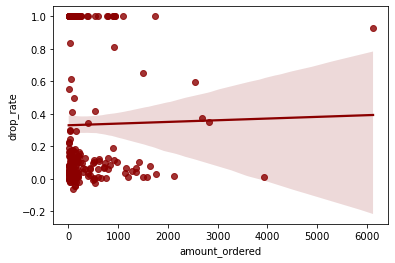

In [44]:
sns.regplot(data = df1, x = 'amount_ordered', y = 'drop_rate', color = 'darkred')

There was very little to no correlation between the amount ordered and drop-rate

### Part 3: Conclusion

The distribution of revenue seems to skew heavily to shops in TP. Đà Nẵng which sells products such as "Nho đen Mỹ" and "Nho xanh không hạt Mỹ" although the drop-rate of these product were quite high. A fast actionable advice for the firm is that they should focus more on getting more volumn of these products and ensure that its quality meet standard.